In [15]:
!nvidia-smi -L

from google.colab import drive
drive.mount("/content/drive")

/bin/bash: line 1: nvidia-smi: command not found
Mounted at /content/drive


In [24]:
!git config --global user.email "luwammajor5@gmail.com"
!git config --global user.name "LuwamMKefali"

In [26]:
!git clone https://github.com/hassen8/emotion_recognition_bias_auditing.git

Cloning into 'emotion_recognition_bias_auditing'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 8), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 1.15 MiB | 14.57 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [27]:
!cp "/content/drive/MyDrive/Colab Notebooks/EmotiEffLib_GRAD_CAM.ipynb" \
    "/content/emotion_recognition_bias_auditing/notebooks/EmotiEffLib_GRAD_CAM.ipynb"

In [28]:
%cd /content/emotion_recognition_bias_auditing/
!git add notebooks/EmotiEffLib_GRAD_CAM.ipynb
!git commit -m "Add EmotiEffLib Grad-CAM pipeline on RAF-DB"

/content/emotion_recognition_bias_auditing
[master 399ce5e] Add EmotiEffLib Grad-CAM pipeline on RAF-DB
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/EmotiEffLib_GRAD_CAM.ipynb (90%)


In [29]:
!git push

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!pip -q install emotiefflib[torch] opencv-python tqdm pandas matplotlib
!pip -q install facenet-pytorch==2.5.3 pillow==10.2.0
!pip -q install grad-cam

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [ ]:
!unzip /content/drive/MyDrive/Image/aligned.zip

Streaming output truncated to the last 5000 lines.
  inflating: aligned/train_07272_aligned.jpg  
  inflating: aligned/train_07273_aligned.jpg  
  inflating: aligned/train_07274_aligned.jpg  
  inflating: aligned/train_07275_aligned.jpg  
  inflating: aligned/train_07276_aligned.jpg  
  inflating: aligned/train_07277_aligned.jpg  
  inflating: aligned/train_07278_aligned.jpg  
  inflating: aligned/train_07279_aligned.jpg  
  inflating: aligned/train_07280_aligned.jpg  
  inflating: aligned/train_07281_aligned.jpg  
  inflating: aligned/train_07282_aligned.jpg  
  inflating: aligned/train_07283_aligned.jpg  
  inflating: aligned/train_07284_aligned.jpg  
  inflating: aligned/train_07285_aligned.jpg  
  inflating: aligned/train_07286_aligned.jpg  
  inflating: aligned/train_07287_aligned.jpg  
  inflating: aligned/train_07288_aligned.jpg  
  inflating: aligned/train_07289_aligned.jpg  
  inflating: aligned/train_07290_aligned.jpg  
  inflating: aligned/train_07291_aligned.jpg  
  inflati

In [ ]:
!cp /content/drive/MyDrive/EmoLabel/list_patition_label.txt .

# Imports + paths

In [ ]:
from pathlib import Path
import os
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image

ALIGNED_DIR = Path("/content/aligned")
LABEL_FILE  = Path("/content/list_patition_label.txt")

print("ALIGNED_DIR exists:", ALIGNED_DIR.exists(), ALIGNED_DIR)
print("LABEL_FILE exists:", LABEL_FILE.exists(), LABEL_FILE)
print("Aligned images (sample):", len(list(ALIGNED_DIR.glob("*.jpg"))))


ALIGNED_DIR exists: True /content/aligned
LABEL_FILE exists: True /content/list_patition_label.txt
Num aligned images (sample): 15339


## Load RAD-DB labels

In [ ]:
def load_raf_labels(label_path: Path) -> pd.DataFrame:
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            fname = parts[0]          # e.g., train_00001.jpg
            lab = int(parts[1])       # 1..7
            rows.append({"fname": fname, "gt_label": lab})
    df = pd.DataFrame(rows)
    return df

df_labels = load_raf_labels(LABEL_FILE)
print("Label rows:", len(df_labels))
df_labels.head()

Label rows: 15339


,fname,gt_label
0,train_00001.jpg,5
1,train_00002.jpg,5
2,train_00003.jpg,4
3,train_00004.jpg,4
4,train_00005.jpg,5


## Map label files names

In [ ]:
# RAF-DB 7-class mapping
RAF_7 = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral",
}

df_labels["gt_emotion"] = df_labels["gt_label"].map(RAF_7)

def label_to_aligned_path(fname_from_labels: str) -> Path:
    stem = Path(fname_from_labels).stem  # train_00001
    return ALIGNED_DIR / f"{stem}_aligned.jpg"

df_labels["aligned_path"] = df_labels["fname"].apply(label_to_aligned_path)

df = df_labels[df_labels["aligned_path"].apply(lambda p: p.exists())].copy().reset_index(drop=True)

print("Total labels:", len(df_labels))
print("Matched aligned images:", len(df))
print("Example aligned file:", df.iloc[0]["aligned_path"])
df.head()


Total labels: 15339
Matched aligned images: 15339
Example aligned file: /content/aligned/train_00001_aligned.jpg


,fname,gt_label,gt_emotion,aligned_path
0,train_00001.jpg,5,sad,/content/aligned/train_00001_aligned.jpg
1,train_00002.jpg,5,sad,/content/aligned/train_00002_aligned.jpg
2,train_00003.jpg,4,happy,/content/aligned/train_00003_aligned.jpg
3,train_00004.jpg,4,happy,/content/aligned/train_00004_aligned.jpg
4,train_00005.jpg,5,sad,/content/aligned/train_00005_aligned.jpg


## Load EmotiEffLib

In [ ]:
from emotiefflib.facial_analysis import EmotiEffLibRecognizer, get_model_list

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

print("Available EmotiEffLib models:\n", get_model_list())

MODEL_NAME = "enet_b0_8_best_vgaf"
emotion_recognizer = EmotiEffLibRecognizer(engine="torch", model_name=MODEL_NAME, device=device)

print("Loaded model:", MODEL_NAME)


device: cpu
Available EmotiEffLib models:
 ['enet_b0_8_best_vgaf', 'enet_b0_8_best_afew', 'enet_b2_8', 'enet_b0_8_va_mtl', 'enet_b2_7', 'mbf_va_mtl', 'mobilevit_va_mtl']
Loaded model: enet_b0_8_best_vgaf


## Unrawp torck model + pick Grad-Cam target layer

In [ ]:
import torch.nn as nn

def unwrap_torch_model(recognizer):
    for attr in ["model", "net", "backbone", "_model"]:
        if hasattr(recognizer, attr):
            m = getattr(recognizer, attr)
            if isinstance(m, nn.Module):
                return m
    for _, v in recognizer.__dict__.items():
        if isinstance(v, nn.Module):
            return v
    raise RuntimeError("Could not find a torch.nn.Module inside EmotiEffLibRecognizer.")

torch_model = unwrap_torch_model(emotion_recognizer).to(device).eval()
print("Torch model type:", type(torch_model))

def find_last_conv_layer(model):
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d layer found for Grad-CAM.")
    return last

target_layer = find_last_conv_layer(torch_model)
print("Grad-CAM target layer:", target_layer)


Torch model type: <class 'timm.models.efficientnet.EfficientNet'>
Grad-CAM target layer: Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Utilities: image reading + prediction

In [ ]:
def read_rgb(path: Path):
    img_bgr = cv2.imread(str(path))
    if img_bgr is None:
        return None
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def predict_emotieff(face_rgb_uint8):
    # EmotiEffLib expects list of RGB uint8 (H,W,3)
    emotions, logits = emotion_recognizer.predict_emotions([face_rgb_uint8], logits=True)
    return emotions[0], logits[0]


# Grad-CAM setup + preprocess

In [ ]:
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def to_model_tensor(face_rgb_uint8, image_size=224):
    tfm = T.Compose([
        T.ToPILImage(),
        T.Resize((image_size, image_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    x = tfm(face_rgb_uint8).unsqueeze(0).to(device)
    return x

def run_gradcam(face_rgb_uint8, image_size=224):
    x = to_model_tensor(face_rgb_uint8, image_size=image_size)

    with torch.no_grad():
        out = torch_model(x)
        if out.ndim == 1:
            out = out.unsqueeze(0)
        cls_idx = int(out.argmax(dim=1).item())

    cam = GradCAM(model=torch_model, target_layers=[target_layer])
    cam_map = cam(input_tensor=x, targets=[ClassifierOutputTarget(cls_idx)])[0]  # HxW

    face_rs = cv2.resize(face_rgb_uint8, (cam_map.shape[1], cam_map.shape[0]))
    face_float = face_rs.astype(np.float32) / 255.0
    cam_vis = show_cam_on_image(face_float, cam_map, use_rgb=True)

    return cls_idx, cam_map, face_rs, cam_vis


## single-image test

Testing sample: /content/aligned/train_00001_aligned.jpg
GT: sad
EmotiEffLib pred: Anger (conf=0.340)
Torch class idx: 524


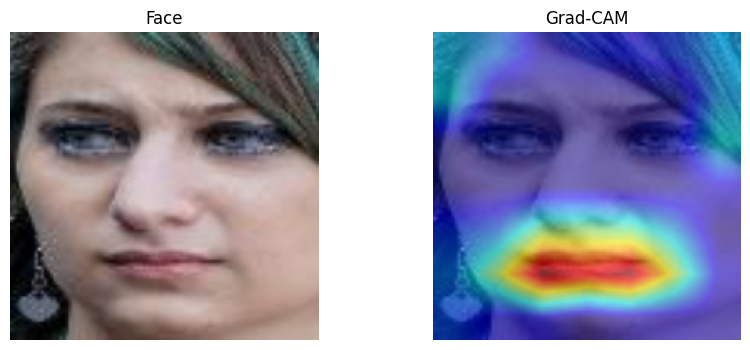

In [ ]:
sample_path = df.iloc[0]["aligned_path"]
print("Testing sample:", sample_path)

face = read_rgb(sample_path)
assert face is not None, f"Could not read image: {sample_path}"

pred_label, pred_logits = predict_emotieff(face)
probs = torch.softmax(torch.tensor(pred_logits), dim=0).cpu().numpy()
pred_conf = float(probs[np.argmax(probs)])

cls_idx, cam_map, face_rs, cam_vis = run_gradcam(face)

print("GT:", df.iloc[0]["gt_emotion"])
print("EmotiEffLib pred:", pred_label, f"(conf={pred_conf:.3f})")
print("Torch class idx:", cls_idx)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(face_rs); plt.axis("off"); plt.title("Face")
plt.subplot(1,2,2); plt.imshow(cam_vis); plt.axis("off"); plt.title("Grad-CAM")
plt.show()


# Barch run + save overlays + CSV

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

OUT_DIR = Path("/content/emotiefflib_gradcam_outputs")
(OUT_DIR / "overlays").mkdir(parents=True, exist_ok=True)

rows_clean = []
rows_debug = []

N = min(20, len(df))  # scale later

for i in tqdm(range(N)):
    fname = df.loc[i, "fname"]
    img_path = df.loc[i, "aligned_path"]
    gt_emotion = df.loc[i, "gt_emotion"]

    # split: "train" or "test" inferred from filename
    split = "train" if Path(fname).stem.startswith("train") else ("test" if Path(fname).stem.startswith("test") else "unknown")

    face = read_rgb(img_path)
    if face is None:
        rows_clean.append({"fname": fname, "split": split, "gt_emotion": gt_emotion, "pred_emotion": None, "pred_conf": None, "status": "read_fail"})
        rows_debug.append({"fname": fname, "aligned_path": str(img_path), "status": "read_fail"})
        continue

    pred_label, pred_logits = predict_emotieff(face)
    probs = torch.softmax(torch.tensor(pred_logits), dim=0).cpu().numpy()
    pred_conf = float(probs[np.argmax(probs)])

    cls_idx, cam_map, face_rs, cam_vis = run_gradcam(face)

    save_path = OUT_DIR / "overlays" / f"{Path(fname).stem}_gt-{gt_emotion}_pred-{pred_label}.png"
    Image.fromarray(cam_vis).save(save_path)

    rows_clean.append({
        "fname": fname,
        "split": split,
        "gt_emotion": gt_emotion,
        "pred_emotion": pred_label,
        "pred_conf": pred_conf,
        "status": "ok",
    })


    rows_debug.append({
        "fname": fname,
        "aligned_path": str(img_path),
        "overlay_path": str(save_path),
        "torch_pred_class_idx": cls_idx,
        "status": "ok",
    })

df_out = pd.DataFrame(rows_clean)
df_debug = pd.DataFrame(rows_debug)

csv_path = OUT_DIR / "predictions_clean.csv"
df_out.to_csv(csv_path, index=False)

# Optional
debug_csv_path = OUT_DIR / "predictions_debug.csv"
df_debug.to_csv(debug_csv_path, index=False)

df_out.head()


100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


,fname,split,gt_emotion,pred_emotion,pred_conf,status
0,train_00001.jpg,train,sad,Anger,0.340186,ok
1,train_00002.jpg,train,sad,Sadness,0.793980,ok
2,train_00003.jpg,train,happy,Happiness,0.771812,ok
3,train_00004.jpg,train,happy,Happiness,0.433389,ok
4,train_00005.jpg,train,sad,Sadness,0.648860,ok


OK overlays: 20


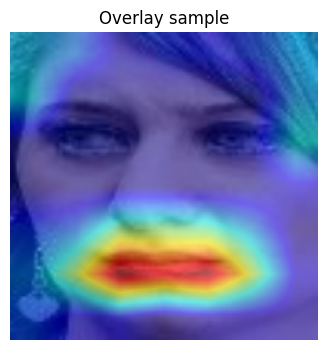

In [ ]:
ok = df_debug[df_debug["status"] == "ok"]
print("OK overlays:", len(ok))

if len(ok) > 0:
    p = ok.iloc[0]["overlay_path"]
    img = Image.open(p)
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Overlay sample")
    plt.show()
